<a href="https://www.kaggle.com/code/ahmedrushdi/rl-pong-ddqn?scriptVersionId=121991475" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
!pip install gym[atari,accept-rom-license] #--quiet
!pip install pygame --quiet
!pip install pyvirtualdisplay --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - \ | / - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Using cached libtorrent-2.0.7-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (8.6 MB)
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.5.5-py3-none-any.whl size=448838 sha256=caed991444f574c73b8939636b119b5464e0bc371f563c69bb47b3b83c32d775
  Stored in directory: /root/.cache/pip/wheels/ff/91/f8/f518dfff78fedfb9076d3439fe8b08c03ced911b2fefcd385e
Successfully built AutoROM.accept-rom-license


In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()


from matplotlib import pyplot as plt, animation
%matplotlib inline
from IPython import display

def create_anim(frames, dpi, fps):
    plt.figure(figsize=(frames[0].shape[1] / dpi, frames[0].shape[0] / dpi), dpi=dpi)
    patch = plt.imshow(frames[0])
    def setup():
        plt.axis('off')
    def animate(i):
        patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, init_func=setup, frames=len(frames), interval=fps)
    return anim

def display_anim(frames, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    return anim.to_jshtml()

def save_anim(frames, filename, dpi=72, fps=50):
    anim = create_anim(frames, dpi, fps)
    anim.save(filename)

In [3]:
from IPython.display import clear_output
import gym
import numpy as np
from tqdm.notebook import tqdm
from tensorflow import keras
import tensorflow as tf
from collections import deque
import random
from keras.backend import int_shape
from tensorflow.keras.models import load_model
import psutil

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:637: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.bool,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:108: DeprecationWarning: `np.object` is a deprecated ali

In [4]:
env = gym.make('PongNoFrameskip-v4')
env = gym.wrappers.AtariPreprocessing(env, noop_max=30, frame_skip=4, screen_size=84, terminal_on_life_loss=False, grayscale_obs=True, grayscale_newaxis=False, scale_obs=True)
env = gym.wrappers.FrameStack(env, 4)

A.L.E: Arcade Learning Environment (version 0.7.5+db37282)
[Powered by Stella]


In [5]:
env.action_space

Discrete(6)

In [6]:
env.observation_space

Box(0.0, 1.0, (4, 84, 84), float32)

In [7]:
# number of frames to run
NUM_FRAMES = 4000000

#number of episodes to run
NUM_EPISODES = 100

#initial episode to continue training (0 if didn't train)
INIT_EPISODE = 400

#max iterations per run
MAX_ITERATIONS = 1000


#epsilon for choosing action
eps = 1 
eps_decay = 0.99

eps = eps*(eps_decay**INIT_EPISODE)

#discount factor for future utility
discount_factor = 0.97

#batch size for exp replay
batch_size = 32

#max memory stored for exp replay
MAX_MEMORY = int(NUM_FRAMES/40)

#initial population of memory using random policy
INIT_MEMORY = int(MAX_MEMORY*0.8)

#update interval to use target network
TARGET_C = int(NUM_FRAMES/1000)

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
#         import pdb; pdb.set_trace()
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=MAX_MEMORY)
        self.gamma = discount_factor    # discount rate
        self.epsilon = eps  # exploration rate
#         self.epsilon_min = eps_min
        self.epsilon_decay = eps_decay
        self.learning_rate = 0.00025
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()
        
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    def _build_model(self):
        model = keras.Sequential(
            [
                keras.layers.Permute((2,3,1), input_shape=self.state_size),
                keras.layers.Conv2D(16, kernel_size=(8, 8), strides=4, activation="relu",),
                keras.layers.Conv2D(32, kernel_size=(4, 4), strides=2, activation="relu"),
                keras.layers.Flatten(),
                keras.layers.Dense(256, activation="relu"),
                keras.layers.Dense(self.action_size, activation="linear"),
            ]
        )
        model.compile(loss='mse',
              optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((np.expand_dims(state, axis=0), action, reward, np.expand_dims(next_state, axis=0), done))

    #get action
    def act(self, state):
        #select random action with prob=epsilon else action=maxQ
#         import pdb; pdb.set_trace()
        state = (np.expand_dims(state, axis=0))
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values)
    
    def replay(self, batch_size):
        #sample random transitions
        
        state, action, reward, next_state, done = zip(*random.sample(self.memory, batch_size))
        state = np.concatenate(state)
        next_state = np.concatenate(next_state)
        action = np.array(action)
        reward = np.array(reward)
        done = np.array(done)
        Q_next=self.model.predict(next_state)
        states_target_q_values = self.target_model.predict(state)
        action_i = (np.arange(batch_size),action)
        n_action_i = (np.arange(batch_size),np.argmax(Q_next, axis=1))
#         import pdb; pdb.set_trace()
        target = reward + self.gamma * Q_next[n_action_i] * (1 - done)
        states_target_q_values[action_i] = target
        self.model.fit(state,states_target_q_values,epochs=1, verbose=0)
        
        
    def train(self, n_episodes, n_iterations):
        
        self.init_mem(INIT_MEMORY)
        scores = []
        iterations = []
        for i in tqdm(range(n_episodes), desc='Episodes'):
            state = env.reset()
            done = False
            score = 0
            frames = 0
            t = tqdm(range(n_iterations), leave=False, desc='iterations', total = 1000)
            for j in t:
                action = self.act(state)
                next_state, reward, done, info = env.step(action)
                self.remember(state, action, reward, next_state, done)
#                 if (j + 1)% (batch_size//4) == 0:
                self.replay(batch_size)
                if j % TARGET_C == 0:
                    
                    self.update_target_model()
                state = next_state
                score += reward
                self.epsilon *= self.epsilon_decay
                if done:
                    t.container.close()
                    iterations.append(j+1)
                    break
            scores.append(score)
            self.save_models()
            print(f'EP{i}: Done with status n_iter: {j+1}, mem_size: {len(self.memory)} {psutil.virtual_memory()}, score: {score}')
        return scores, iterations
    
    def init_mem(self, mem_n):
        for i in tqdm(range(mem_n//1000), desc = 'initializing memory'):
            state = env.reset()

            done = False
            t = tqdm(range(1000), leave=False, desc='iterations')
            for j in t:

                action = self.act(state)

                next_state, reward, done, info = env.step(action)

                self.remember(state, action, reward, next_state, done)

                state = next_state
                if done:
                    t.container.close()
                    break
        print(len(self.memory))
                
        
    def save_models(self):
        self.model.save(f'/kaggle/working/model_{INIT_EPISODE+NUM_EPISODES}.h5')        
        self.target_model.save(f'/kaggle/working/target_model_{INIT_EPISODE+NUM_EPISODES}.h5')
    
    def load_models(self, m_link, tm_link):
        self.model = load_model(m_link)        
        self.target_model = load_model(tm_link)



In [9]:
agent = DQNAgent(env.reset().shape,env.action_space.n)
# agent.load_models("../input/pongmodel/model.h5","../input/pongmodel/target_model.h5")
agent.load_models(f"../input/pongmodel/model_{INIT_EPISODE}.h5",f"../input/pongmodel/target_model_{INIT_EPISODE}.h5")

initializing memory:   0%|          | 0/80 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

80000


Episodes:   0%|          | 0/100 [00:00<?, ?it/s]

iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP0: Done with status n_iter: 1000, mem_size: 81000 svmem(total=33669992448, available=13597913088, percent=59.6, used=19593900032, free=7572221952, active=1507602432, inactive=23945084928, buffers=1200046080, cached=5303824384, shared=995328, slab=498851840), score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP1: Done with status n_iter: 1000, mem_size: 82000 svmem(total=33669992448, available=13375922176, percent=60.3, used=19815981056, free=7328997376, active=1507880960, inactive=24189956096, buffers=1200316416, cached=5324697600, shared=995328, slab=499761152), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP2: Done with status n_iter: 1000, mem_size: 83000 svmem(total=33669992448, available=13177946112, percent=60.9, used=20013957120, free=7118868480, active=1508110336, inactive=24415375360, buffers=1200537600, cached=5336629248, shared=995328, slab=500219904), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP3: Done with status n_iter: 1000, mem_size: 84000 svmem(total=33669992448, available=12891791360, percent=61.7, used=20300115968, free=6827790336, active=1508335616, inactive=24695734272, buffers=1200758784, cached=5341327360, shared=995328, slab=500088832), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP4: Done with status n_iter: 1000, mem_size: 85000 svmem(total=33669992448, available=12641099776, percent=62.5, used=20550807552, free=6576046080, active=1508556800, inactive=24929890304, buffers=1200979968, cached=5342158848, shared=995328, slab=500277248), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP5: Done with status n_iter: 1000, mem_size: 86000 svmem(total=33669992448, available=12397174784, percent=63.2, used=20794732544, free=6331269120, active=1508757504, inactive=25185910784, buffers=1201176576, cached=5342814208, shared=995328, slab=500391936), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP6: Done with status n_iter: 1000, mem_size: 87000 svmem(total=33669992448, available=12187160576, percent=63.8, used=21004718080, free=6120259584, active=1508954112, inactive=25374171136, buffers=1201381376, cached=5343633408, shared=995328, slab=500580352), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP7: Done with status n_iter: 1000, mem_size: 88000 svmem(total=33669992448, available=11935477760, percent=64.6, used=21256429568, free=5867929600, active=1509175296, inactive=25624506368, buffers=1201594368, cached=5344038912, shared=995328, slab=500473856), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP8: Done with status n_iter: 1000, mem_size: 89000 svmem(total=33669992448, available=11714207744, percent=65.2, used=21477699584, free=5646258176, active=1509388288, inactive=25861222400, buffers=1201807360, cached=5344227328, shared=995328, slab=500375552), score: -2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP9: Done with status n_iter: 1000, mem_size: 90000 svmem(total=33669992448, available=11510812672, percent=65.8, used=21681065984, free=5442240512, active=1509601280, inactive=26066231296, buffers=1202020352, cached=5344665600, shared=995328, slab=500535296), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP10: Done with status n_iter: 1000, mem_size: 91000 svmem(total=33669992448, available=11247300608, percent=66.6, used=21944606720, free=5178187776, active=1509822464, inactive=26316345344, buffers=1202241536, cached=5344956416, shared=995328, slab=500776960), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP11: Done with status n_iter: 1000, mem_size: 92000 svmem(total=33669992448, available=11033034752, percent=67.2, used=22158872576, free=4963229696, active=1510043648, inactive=26545577984, buffers=1202462720, cached=5345427456, shared=995328, slab=500445184), score: -3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP12: Done with status n_iter: 1000, mem_size: 93000 svmem(total=33669992448, available=10786193408, percent=68.0, used=22405713920, free=4715925504, active=1510268928, inactive=26777726976, buffers=1202688000, cached=5345665024, shared=995328, slab=500518912), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP13: Done with status n_iter: 1000, mem_size: 94000 svmem(total=33669992448, available=10590085120, percent=68.5, used=22601822208, free=4519329792, active=1510596608, inactive=26972925952, buffers=1202917376, cached=5345923072, shared=995328, slab=500707328), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP14: Done with status n_iter: 1000, mem_size: 95000 svmem(total=33669992448, available=10327117824, percent=69.3, used=22864789504, free=4255924224, active=1510834176, inactive=27240177664, buffers=1203154944, cached=5346123776, shared=995328, slab=500850688), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP15: Done with status n_iter: 1000, mem_size: 96000 svmem(total=33669992448, available=10112983040, percent=70.0, used=23078924288, free=4041330688, active=1511055360, inactive=27469463552, buffers=1203367936, cached=5346369536, shared=995328, slab=500539392), score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP16: Done with status n_iter: 1000, mem_size: 97000 svmem(total=33669992448, available=9889419264, percent=70.6, used=23302488064, free=3817316352, active=1511288832, inactive=27689058304, buffers=1203597312, cached=5346590720, shared=995328, slab=500527104), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP17: Done with status n_iter: 1000, mem_size: 98000 svmem(total=33669992448, available=9616875520, percent=71.4, used=23574806528, free=3544535040, active=1511505920, inactive=27954872320, buffers=1203810304, cached=5346840576, shared=995328, slab=500764672), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP18: Done with status n_iter: 1000, mem_size: 99000 svmem(total=33669992448, available=9417060352, percent=72.0, used=23774851072, free=3344039936, active=1511710720, inactive=28151197696, buffers=1204015104, cached=5347086336, shared=991232, slab=500985856), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP19: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9137131520, percent=72.9, used=24054775808, free=3063644160, active=1511936000, inactive=28400742400, buffers=1204244480, cached=5347328000, shared=995328, slab=500711424), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP20: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9141219328, percent=72.9, used=24050688000, free=3067310080, active=1512132608, inactive=28400918528, buffers=1204441088, cached=5347553280, shared=995328, slab=500744192), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP21: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9207001088, percent=72.7, used=23984906240, free=3132657664, active=1512329216, inactive=28367761408, buffers=1204637696, cached=5347790848, shared=995328, slab=500985856), score: 8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP22: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9143685120, percent=72.8, used=24048222208, free=3068923904, active=1512566784, inactive=28401012736, buffers=1204875264, cached=5347971072, shared=995328, slab=501096448), score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP23: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9191542784, percent=72.7, used=24000364544, free=3116339200, active=1512779776, inactive=28373938176, buffers=1205088256, cached=5348200448, shared=995328, slab=500809728), score: 8.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP24: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9148387328, percent=72.8, used=24043520000, free=3072679936, active=1512992768, inactive=28400312320, buffers=1205301248, cached=5348491264, shared=995328, slab=500875264), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP25: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9136427008, percent=72.9, used=24055480320, free=3060293632, active=1513205760, inactive=28420542464, buffers=1205514240, cached=5348704256, shared=995328, slab=501039104), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP26: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9137446912, percent=72.9, used=24054460416, free=3060871168, active=1513410560, inactive=28406349824, buffers=1205710848, cached=5348950016, shared=995328, slab=501268480), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP27: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9147809792, percent=72.8, used=24044097536, free=3070877696, active=1513607168, inactive=28409061376, buffers=1205907456, cached=5349109760, shared=995328, slab=500908032), score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP28: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9129594880, percent=72.9, used=24062304256, free=3052199936, active=1513820160, inactive=28423749632, buffers=1206128640, cached=5349359616, shared=995328, slab=500998144), score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP29: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9168068608, percent=72.8, used=24023830528, free=3090165760, active=1514078208, inactive=28386242560, buffers=1206358016, cached=5349638144, shared=995328, slab=501248000), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP30: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9114025984, percent=72.9, used=24077881344, free=3035705344, active=1514291200, inactive=28424450048, buffers=1206558720, cached=5349847040, shared=995328, slab=500994048), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP31: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9148493824, percent=72.8, used=24043413504, free=3069710336, active=1514545152, inactive=28426252288, buffers=1206812672, cached=5350055936, shared=995328, slab=500989952), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP32: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9112383488, percent=72.9, used=24079527936, free=3033063424, active=1514778624, inactive=28427374592, buffers=1207042048, cached=5350359040, shared=991232, slab=501055488), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP33: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9109647360, percent=72.9, used=24082259968, free=3029827584, active=1514995712, inactive=28428066816, buffers=1207263232, cached=5350641664, shared=995328, slab=501284864), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP34: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9136590848, percent=72.9, used=24055316480, free=3056365568, active=1515192320, inactive=28424425472, buffers=1207459840, cached=5350850560, shared=995328, slab=501510144), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP35: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9136381952, percent=72.9, used=24055525376, free=3055710208, active=1515413504, inactive=28424896512, buffers=1207681024, cached=5351075840, shared=995328, slab=501166080), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP36: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9107001344, percent=73.0, used=24084905984, free=3025870848, active=1515642880, inactive=28432707584, buffers=1207910400, cached=5351305216, shared=995328, slab=501256192), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP37: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9153359872, percent=72.8, used=24038547456, free=3071782912, active=1515847680, inactive=28425973760, buffers=1208115200, cached=5351546880, shared=995328, slab=501440512), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP38: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9156345856, percent=72.8, used=24035561472, free=3074363392, active=1516036096, inactive=28398981120, buffers=1208328192, cached=5351739392, shared=995328, slab=501248000), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP39: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9124442112, percent=72.9, used=24067465216, free=3041910784, active=1516265472, inactive=28431249408, buffers=1208532992, cached=5352083456, shared=995328, slab=501358592), score: 7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP40: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9133056000, percent=72.9, used=24058851328, free=3049988096, active=1516494848, inactive=28426227712, buffers=1208762368, cached=5352390656, shared=995328, slab=501481472), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP41: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9107648512, percent=73.0, used=24084258816, free=3024142336, active=1516703744, inactive=28435734528, buffers=1208967168, cached=5352624128, shared=995328, slab=501633024), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP42: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9144225792, percent=72.8, used=24047681536, free=3060269056, active=1516908544, inactive=28417011712, buffers=1209171968, cached=5352869888, shared=995328, slab=501411840), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP43: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9094463488, percent=73.0, used=24097443840, free=3010117632, active=1517121536, inactive=28461215744, buffers=1209384960, cached=5353046016, shared=995328, slab=501415936), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP44: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9103716352, percent=73.0, used=24088190976, free=3018903552, active=1517334528, inactive=28462964736, buffers=1209597952, cached=5353299968, shared=995328, slab=501518336), score: -7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP45: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9100947456, percent=73.0, used=24090959872, free=3015712768, active=1517563904, inactive=28454481920, buffers=1209819136, cached=5353500672, shared=995328, slab=501731328), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP46: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9102655488, percent=73.0, used=24089251840, free=3016962048, active=1517789184, inactive=28466274304, buffers=1210044416, cached=5353734144, shared=995328, slab=501522432), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP47: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9084022784, percent=73.0, used=24108072960, free=2997915648, active=1518018560, inactive=28458737664, buffers=1210273792, cached=5353730048, shared=995328, slab=501395456), score: 7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP48: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9072033792, percent=73.1, used=24119873536, free=2985467904, active=1518264320, inactive=28471234560, buffers=1210478592, cached=5354172416, shared=995328, slab=501522432), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP49: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9074601984, percent=73.0, used=24117309440, free=2987573248, active=1518489600, inactive=28465582080, buffers=1210699776, cached=5354409984, shared=991232, slab=501702656), score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP50: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9084186624, percent=73.0, used=24107720704, free=2996641792, active=1518723072, inactive=28461887488, buffers=1210937344, cached=5354692608, shared=995328, slab=501530624), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP51: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9087528960, percent=73.0, used=24104378368, free=2999558144, active=1518927872, inactive=28480729088, buffers=1211142144, cached=5354913792, shared=995328, slab=501563392), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP52: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9090641920, percent=73.0, used=24101265408, free=3002228736, active=1519144960, inactive=28472721408, buffers=1211359232, cached=5355139072, shared=995328, slab=501649408), score: 7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP53: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9095540736, percent=73.0, used=24096366592, free=3006701568, active=1519345664, inactive=28441939968, buffers=1211559936, cached=5355364352, shared=995328, slab=501800960), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP54: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9110396928, percent=72.9, used=24081510400, free=3021058048, active=1519566848, inactive=28462645248, buffers=1211781120, cached=5355642880, shared=995328, slab=501645312), score: 10.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP55: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9097175040, percent=73.0, used=24094732288, free=3007401984, active=1519783936, inactive=28479848448, buffers=1211998208, cached=5355859968, shared=995328, slab=501653504), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP56: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9072803840, percent=73.1, used=24119103488, free=2982449152, active=1519988736, inactive=28485664768, buffers=1212203008, cached=5356236800, shared=995328, slab=501923840), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP57: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9076621312, percent=73.0, used=24115286016, free=2985889792, active=1520209920, inactive=28473991168, buffers=1212424192, cached=5356392448, shared=995328, slab=502079488), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP58: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9062793216, percent=73.1, used=24129114112, free=2971627520, active=1520431104, inactive=28483833856, buffers=1212645376, cached=5356605440, shared=995328, slab=502116352), score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP59: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9035472896, percent=73.2, used=24156434432, free=2943885312, active=1520627712, inactive=28486782976, buffers=1212841984, cached=5356830720, shared=995328, slab=501780480), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP60: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9064923136, percent=73.1, used=24126980096, free=2972864512, active=1520848896, inactive=28485894144, buffers=1213063168, cached=5357084672, shared=995328, slab=501932032), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP61: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9056657408, percent=73.1, used=24135249920, free=2964099072, active=1521070080, inactive=28485124096, buffers=1213284352, cached=5357359104, shared=995328, slab=502140928), score: 5.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP62: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9071104000, percent=73.1, used=24120799232, free=2978140160, active=1521291264, inactive=28479561728, buffers=1213505536, cached=5357547520, shared=995328, slab=502235136), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP63: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9060884480, percent=73.1, used=24131022848, free=2967465984, active=1521520640, inactive=28486045696, buffers=1213734912, cached=5357768704, shared=995328, slab=501829632), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP64: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9047736320, percent=73.1, used=24144171008, free=2953895936, active=1521717248, inactive=28497862656, buffers=1213931520, cached=5357993984, shared=995328, slab=501936128), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP65: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9051824128, percent=73.1, used=24140083200, free=2957541376, active=1521946624, inactive=28499169280, buffers=1214160896, cached=5358206976, shared=995328, slab=502181888), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP66: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9061888000, percent=73.1, used=24130019328, free=2967109632, active=1522135040, inactive=28486377472, buffers=1214349312, cached=5358514176, shared=995328, slab=502386688), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP67: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9060552704, percent=73.1, used=24131354624, free=2965360640, active=1522323456, inactive=28493520896, buffers=1214537728, cached=5358739456, shared=995328, slab=502071296), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP68: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9051828224, percent=73.1, used=24140079104, free=2956267520, active=1522483200, inactive=28498894848, buffers=1214697472, cached=5358948352, shared=995328, slab=502022144), score: 7.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP69: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9085628416, percent=73.0, used=24106278912, free=2989641728, active=1522667520, inactive=28490772480, buffers=1214881792, cached=5359190016, shared=995328, slab=502288384), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP70: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9063985152, percent=73.1, used=24127922176, free=2967687168, active=1522810880, inactive=28491177984, buffers=1215041536, cached=5359341568, shared=995328, slab=502452224), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP71: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9085386752, percent=73.0, used=24106520576, free=2988572672, active=1522995200, inactive=28493791232, buffers=1215209472, cached=5359689728, shared=995328, slab=502116352), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP72: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9059700736, percent=73.1, used=24132206592, free=2962522112, active=1523150848, inactive=28493328384, buffers=1215365120, cached=5359898624, shared=995328, slab=502169600), score: -4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP73: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9070211072, percent=73.1, used=24121696256, free=2972647424, active=1523310592, inactive=28510863360, buffers=1215524864, cached=5360123904, shared=995328, slab=502353920), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP74: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9061916672, percent=73.1, used=24129990656, free=2963980288, active=1523490816, inactive=28506537984, buffers=1215705088, cached=5360316416, shared=995328, slab=502464512), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP75: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9062064128, percent=73.1, used=24129843200, free=2963808256, active=1523642368, inactive=28502654976, buffers=1215856640, cached=5360484352, shared=995328, slab=502054912), score: 2.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP76: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9062375424, percent=73.1, used=24129531904, free=2963660800, active=1523822592, inactive=28503863296, buffers=1216036864, cached=5360762880, shared=995328, slab=502112256), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP77: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9035014144, percent=73.2, used=24156893184, free=2935881728, active=1523990528, inactive=28510273536, buffers=1216204800, cached=5361012736, shared=995328, slab=502370304), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP78: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9054322688, percent=73.1, used=24137584640, free=2954825728, active=1524129792, inactive=28503523328, buffers=1216344064, cached=5361238016, shared=995328, slab=502575104), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP79: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9047306240, percent=73.1, used=24144601088, free=2947432448, active=1524318208, inactive=28511006720, buffers=1216520192, cached=5361438720, shared=995328, slab=502194176), score: 11.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP80: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9041985536, percent=73.1, used=24149921792, free=2941657088, active=1524494336, inactive=28510670848, buffers=1216696320, cached=5361717248, shared=995328, slab=502292480), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP81: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9046233088, percent=73.1, used=24145674240, free=2945564672, active=1524645888, inactive=28524347392, buffers=1216847872, cached=5361905664, shared=995328, slab=502464512), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP82: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9046560768, percent=73.1, used=24145342464, free=2945462272, active=1524834304, inactive=28512694272, buffers=1217036288, cached=5362151424, shared=995328, slab=502620160), score: 9.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP83: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9031434240, percent=73.2, used=24160468992, free=2930073600, active=1525047296, inactive=28527898624, buffers=1217249280, cached=5362200576, shared=995328, slab=502358016), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP84: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9051840512, percent=73.1, used=24140066816, free=2949873664, active=1525252096, inactive=28511649792, buffers=1217454080, cached=5362597888, shared=995328, slab=502444032), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP85: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9078329344, percent=73.0, used=24113577984, free=2975997952, active=1525420032, inactive=28513611776, buffers=1217626112, cached=5362790400, shared=995328, slab=502579200), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP86: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9024937984, percent=73.2, used=24166969344, free=2922258432, active=1525583872, inactive=28531040256, buffers=1217785856, cached=5362978816, shared=995328, slab=502317056), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP87: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9024942080, percent=73.2, used=24166965248, free=2921861120, active=1525755904, inactive=28531511296, buffers=1217957888, cached=5363208192, shared=995328, slab=502341632), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP88: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9031561216, percent=73.2, used=24160346112, free=2928283648, active=1525915648, inactive=28530724864, buffers=1218117632, cached=5363245056, shared=995328, slab=502538240), score: 3.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP89: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9030176768, percent=73.2, used=24161730560, free=2926235648, active=1526079488, inactive=28533411840, buffers=1218281472, cached=5363744768, shared=995328, slab=502714368), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP90: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9034403840, percent=73.2, used=24157503488, free=2930057216, active=1526251520, inactive=28527591424, buffers=1218453504, cached=5363978240, shared=995328, slab=502497280), score: 0.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP91: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9034506240, percent=73.2, used=24157401088, free=2929819648, active=1526394880, inactive=28526759936, buffers=1218596864, cached=5364174848, shared=995328, slab=502558720), score: 6.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP92: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9036087296, percent=73.2, used=24155820032, free=2931056640, active=1526566912, inactive=28528500736, buffers=1218768896, cached=5364346880, shared=995328, slab=502636544), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP93: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9021411328, percent=73.2, used=24170496000, free=2915991552, active=1526718464, inactive=28538626048, buffers=1218920448, cached=5364584448, shared=995328, slab=502857728), score: 4.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP94: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9026064384, percent=73.2, used=24165842944, free=2920259584, active=1526870016, inactive=28538245120, buffers=1219072000, cached=5364817920, shared=995328, slab=502628352), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP95: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9058713600, percent=73.1, used=24133193728, free=2952531968, active=1527021568, inactive=28532518912, buffers=1219223552, cached=5365043200, shared=995328, slab=502689792), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP96: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9055174656, percent=73.1, used=24136732672, free=2948534272, active=1527246848, inactive=28502724608, buffers=1219416064, cached=5365309440, shared=995328, slab=502829056), score: 12.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP97: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9038749696, percent=73.2, used=24153157632, free=2931650560, active=1527455744, inactive=28544425984, buffers=1219624960, cached=5365559296, shared=995328, slab=502939648), score: -1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP98: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9036185600, percent=73.2, used=24155721728, free=2928562176, active=1527660544, inactive=28545462272, buffers=1219829760, cached=5365878784, shared=995328, slab=502767616), score: 1.0


iterations:   0%|          | 0/1000 [00:00<?, ?it/s]

EP99: Done with status n_iter: 1000, mem_size: 100000 svmem(total=33669992448, available=9018703872, percent=73.2, used=24173203456, free=2910658560, active=1527832576, inactive=28542513152, buffers=1219997696, cached=5366132736, shared=995328, slab=502738944), score: -1.0


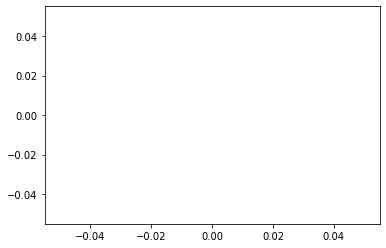

In [10]:
scores, n_iters = agent.train(NUM_EPISODES, MAX_ITERATIONS)
plt.plot(n_iters)

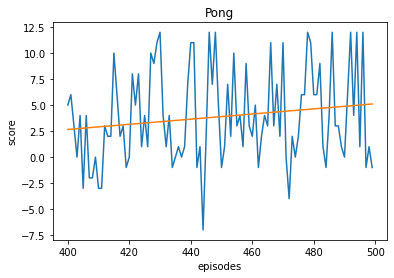

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns

# sns.set()
x = range(INIT_EPISODE,NUM_EPISODES+INIT_EPISODE)
plt.plot(x,scores)
plt.ylabel('score')
plt.xlabel('episodes')
plt.title('Pong')

reg = LinearRegression().fit(np.arange(len(scores)).reshape(-1, 1), np.array(scores).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(scores)).reshape(-1, 1))
plt.plot(x,y_pred)
plt.show()

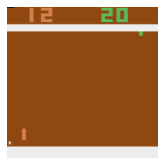

In [12]:
import cv2
def animate():
    frames = []
    state = env.reset()
    done = False
    while not done:
        frames.append(cv2.resize(env.render(mode='rgb_array'), (200, 200)))
        action = np.argmax(agent.model.predict(np.expand_dims(state,axis = 0)), axis=1)[0]
        state, _, done, _ = env.step(action)
    return frames
display.HTML(display_anim(animate(),fps = 24))